<a href="https://colab.research.google.com/github/rusamentiaga/pytorch-test/blob/main/4_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos y transfer learning

La ventaja de los modelos de aprendizaje automático es que no es necesario crearlos desde cero, se puede partir de modelos prediseñados que se adapten a nuestro problema. Además, se puede partir de modelos pre-entrenados, donde solamente se entrenen capas específicas para adaptarlas a un problema concreto

# Dataset cifar-10

Para demostrar el funcionamiento del transfer learning se va a utilizar un dataset disponible en torchvision: [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Se cargan los paquetes.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Se configura el dispositivo

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Se define una transformación para adaptar el dataset al tamaño de entrada que espera la red. Además, se normaliza.

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Se descarga el dataset y se configuran los cargadores.

In [4]:
batch_size = 4

#Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

#Class labels

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
num_classes = len(classes)


Files already downloaded and verified
Files already downloaded and verified


Se comprueba que los ficheros están en disco.

In [5]:
!ls data/cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


Se puede ver el tamaño de cada batch.

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape


torch.Size([4, 3, 224, 224])

In [7]:
print(f'Train images: {len(train_data)}')
print(f'Test images: {len(test_data)}')
print(f'Train batches: {int(len(train_data)/batch_size)}')

Train images: 50000
Test images: 10000
Train batches: 12500


Se visualiza un batch. El dataset contiene imágenes a baja resolución de 10 clases.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' Frog  Deer  Deer  Frog')

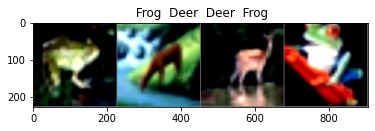

In [8]:
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images)
grid.shape

# unnormalize
grid = grid / 2 + 0.5     
plt.imshow(grid.permute(1,2,0))

plt.title(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Partiendo de un modelo prediseñado

En este caso se va a partir de [AlexNet](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py). Se puede descargar con los parámetros entrenados en [ImageNet](https://www.google.com/search?q=Imagenet).


In [9]:
alexnet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Para adaptarlo al problema concreto hay que cambiar la última capa.

In [10]:
#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
alexnet.classifier[6] = torch.nn.Linear(4096,num_classes)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se define la función de entrenamiento.

In [11]:
import time

def train_model(model, criterion, optimizer):
  # Train the model
  total_step = len(trainloader)
  for epoch in range(num_epochs):
      start = time.time()
      for i, (images, labels) in enumerate(trainloader):
          images = images.to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              end = time.time()
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss}, Time: {end - start}')
              start = time.time()

Se define la función de evaluación.

In [12]:
def eval_model(model):
  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model using the test images: {} %'.format(100 * correct / total)) 

Se realiza el entrenamiento del modelo con una determinada configuración

In [13]:
# Hyperparameters
num_epochs = 1
learning_rate = 0.001
momentum = 0.9

# Model
model = alexnet.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/1], Step [100/12500], Loss: 1.739173173904419, Time: 3.995497465133667
Epoch [1/1], Step [200/12500], Loss: 1.5439192056655884, Time: 3.8086097240448
Epoch [1/1], Step [300/12500], Loss: 2.091404676437378, Time: 3.816885232925415
Epoch [1/1], Step [400/12500], Loss: 1.5327808856964111, Time: 3.8204336166381836
Epoch [1/1], Step [500/12500], Loss: 0.23738159239292145, Time: 3.8207907676696777
Epoch [1/1], Step [600/12500], Loss: 1.9778140783309937, Time: 3.8247852325439453
Epoch [1/1], Step [700/12500], Loss: 1.1550003290176392, Time: 3.822183132171631
Epoch [1/1], Step [800/12500], Loss: 0.9734580516815186, Time: 3.8134114742279053
Epoch [1/1], Step [900/12500], Loss: 0.7920933365821838, Time: 3.8150103092193604
Epoch [1/1], Step [1000/12500], Loss: 1.9260953664779663, Time: 3.807141065597534
Epoch [1/1], Step [1100/12500], Loss: 1.9177700281143188, Time: 3.798126459121704
Epoch [1/1], Step [1200/12500], Loss: 0.9490926861763, Time: 3.814890146255493
Epoch [1/1], Step [1300/12

# Bloqueando capas
Durante el entrenamiento se puede bloquear el entrenamiento de ciertas capas para acelerar el proceso.


In [14]:
alexnet_lock = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet_lock.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se especifíca que no se cácule gradiente para el modelo.

In [15]:
# Freeze model weights
for param in alexnet_lock.parameters():
    param.requires_grad = False

Se añade una nueva capa de clasificación. Cuando se añade un nueva capa, por defecto se establece que sí se cálculo el gradiente y, por tanto, se permite su entrenamiento.

In [16]:
alexnet_lock.classifier[6] = torch.nn.Linear(4096, num_classes)
alexnet_lock.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se puede también cambiar un conjunto de capas y reducir por ejemplo la complejidad de 4096 a 512 en la última capa.

In [17]:
alexnet_lock.classifier = torch.nn.Sequential(
  torch.nn.Dropout(),
  torch.nn.Linear(256 * 6 * 6, 4096),
  torch.nn.ReLU(inplace=True),
  torch.nn.Dropout(),
  torch.nn.Linear(4096, 512),
  torch.nn.ReLU(inplace=True),
  torch.nn.Linear(512, num_classes),
)
alexnet_lock.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se pueden observar los parámetros bloqueados. En otro tipo de redes y con imágenes de más resolución se pueden reducir los parámetros a entrenar en un 99%.

In [18]:
total_params = sum(p.numel() for p in alexnet_lock.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in alexnet_lock.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

42,325,322 total parameters.
39,855,626 training parameters.


Se configurarn los parámetros y realiza el entrenamiento y la evaluación.

In [25]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001
momentum = 0.9

# Model
model = alexnet_lock.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/5], Step [100/12500], Loss: 0.6768792271614075, Time: 2.28712797164917
Epoch [1/5], Step [200/12500], Loss: 1.2921921014785767, Time: 2.06318998336792
Epoch [1/5], Step [300/12500], Loss: 0.06523159146308899, Time: 2.066406011581421
Epoch [1/5], Step [400/12500], Loss: 0.7063745260238647, Time: 2.059244155883789
Epoch [1/5], Step [500/12500], Loss: 1.0930876731872559, Time: 2.0623884201049805
Epoch [1/5], Step [600/12500], Loss: 1.8319004774093628, Time: 2.059964179992676
Epoch [1/5], Step [700/12500], Loss: 0.13611701130867004, Time: 2.0628058910369873
Epoch [1/5], Step [800/12500], Loss: 5.272274971008301, Time: 2.060971260070801
Epoch [1/5], Step [900/12500], Loss: 0.6704246401786804, Time: 2.0642452239990234
Epoch [1/5], Step [1000/12500], Loss: 0.567572832107544, Time: 2.0604960918426514
Epoch [1/5], Step [1100/12500], Loss: 0.48861798644065857, Time: 2.0598976612091064
Epoch [1/5], Step [1200/12500], Loss: 0.5417618155479431, Time: 2.060028553009033
Epoch [1/5], Step [13


# Más modelos

El dataset cifar-10 es muy común para analizar el rendimiento de nuevos modelos. Se puede comprobar [la precisión de los nuevos modelos](https://benchmarks.ai/cifar-10).

En PyTorch hay disponibles más [modelos](https://pytorch.org/vision/stable/models.html) para poder hacer pruebas.



Se pueden comparar los modelos en función de su complejidad.

In [20]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [21]:
total_params = sum(p.numel() for p in vgg16.parameters())
print(f'Total params: {total_params:,}');

Total params: 138,357,544


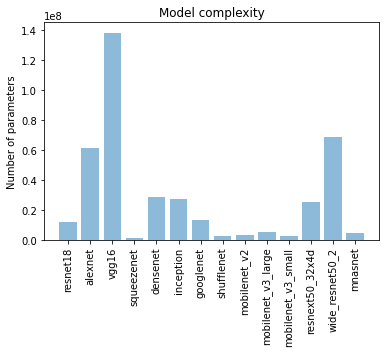

In [22]:
m = []

m.append(resnet18)
m.append(alexnet)
m.append(vgg16)
m.append(squeezenet)
m.append(densenet)
m.append(inception)
m.append(googlenet)
m.append(shufflenet)
m.append(mobilenet_v2)
m.append(mobilenet_v3_large)
m.append(mobilenet_v3_small)
m.append(resnext50_32x4d)
m.append(wide_resnet50_2)
m.append(mnasnet)

params = []
for model in m:
  params.append(sum(p.numel() for p in model.parameters()))

tparams = torch.tensor(params)
objects = ('resnet18', 'alexnet', 'vgg16', 'squeezenet', 'densenet', 
           'inception', 'googlenet', 'shufflenet', 'mobilenet_v2', 'mobilenet_v3_large', 
           'mobilenet_v3_small', 'resnext50_32x4d', 'wide_resnet50_2', 'mnasnet')
pos = range(len(objects))

y=plt.bar(pos, params, align='center', alpha=0.5)
plt.xticks(pos, objects, rotation='vertical')
plt.ylabel('Number of parameters')
plt.title('Model complexity')

plt.show()
